In [127]:
%matplotlib inline*

KeyError: 'inline*'

# TPB04 : Régression : modélisation du diffusiomètre NSCAT

### Introduction 
A l’aide des Perceptrons Multicouches (PMC), on veut simuler la fonction directe d’un diffusiomètre satellitaire mais aussi estimer la variance.  

Le diffusiomètre est un radar actif d’observation de la surface océanique (actif car il possède son propre source d’illumination de la surface d’observation, par rapport à d’autres radars dits passifs qui utilisent le rayonnement solaire). Son principe de mesure est basé sur la réflexion diffuse des ondes électromagnétiques qu’il a émises et qui sont diffusées dans toutes les directions par la surface océanique.  
Le coefficient de rétrodiffusion qu’il mesure est le rapport entre la puissance diffusée dans la direction du radar donc rétrodiffusée et la puissance incidente émise. Ce coefficient de rétrodiffusion (noté ***sigma0*** ou ***s0***) dépend de la rugosité de la surface de l’océan, de la géométrie de mesure (angle de visée ou d’incidence ***q***) et des caractéristiques du radar (la fréquence du signal utilisé, la polarisation des ondes électromagnétiques). 
La rugosité de surface dépend au premier ordre d’approximation du vent local soufflant sur la surface. Le vent engendre,
par l’intermédiaire d’une force de frottement, des vaguelettes de quelques centimètres de ***LO***   (longueur d’onde ou la distance entre 2 crêtes) qui elles interagissent avec les ondes émises par le radar, ondes aussi de quelques centimètres de ***LO***, selon les caractéristiques radars utilisées

Le diffusiomètre effectue des mesures à incidence oblique (***q*** entre 20$^oC$ et 50$^oC$), plus le vent est fort, plus la diffusion est importante et donc plus la mesure radar est forte. En résumé : à vent fort, diffusion plus importante dans toutes les directions et signal mesuré fort, tandis qu’à vent faible, faible diffusion dans la direction du radar et donc signal mesuré plus faible. 
Dans le cadre de ce projet, le diffusiomètre est NSCAT de la NASA. Il travaille en bande Ku ( 14 GHz ) et effectue des mesures en polarisations verticale ( VV ) et horizontale ( HH ) de ***s0*** .


In [128]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor

## Chargement des données

Les données mises à disposition sont constituées d’une base de données issue du radar NSCAT du satellite SeaScat. 
Leur taille et d’un peu plus de 4000 exemples. 4 fichiers sont inclus :
 * Diffu_Dir.dat : Angle d'azimut (en degré) ou direction du vent (***c***)
 * Diffu_Inc.dat : Angle d'incidence (en degré) du signal (***q***)
 * Diffu_Vit.dat : Module de la vitesse du vent : ***n*** (en m/s).
 * Diffu_Sig.dat : ***Sigma0*** (ou s0), composante HH uniquement (en ***dB***)
 
Cette base n'est pas égalisée (voir histogrammes de fréquences ci-dessous), il y a bien plus d'exemples pour les basses vitesses que pour les hautes. Certains angles d'azimut sont mieux représentés que d'autres.

In [129]:
# Chargement des donnees brutes,
direction = np.loadtxt("Diffu_Dir.dat")[:,None]
vitesse    = np.loadtxt("Diffu_Vit.dat")[:,None]
incidence = np.loadtxt("Diffu_Inc.dat")[:,None]
sigma0    = np.loadtxt("Diffu_Sig.dat")[:,None]

In [130]:
direction_sin = np.sin(direction/180*np.pi)
direction_cos = np.cos(direction/180*np.pi)

In [131]:
X = np.hstack((direction,direction_sin,direction_cos,vitesse,incidence,sigma0))
variables = ['Direction','Direction (sin)','Direction (cos)','Vitesse','Incidence','Sigma0']
nombreDeDonnees   = len(sigma0)

In [132]:
df = pd.DataFrame(X,columns=variables)
df.describe()

,Direction,Direction (sin),Direction (cos),Vitesse,Incidence,Sigma0
count,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000
mean,188.441481,0.010634,-0.012867,8.281703,34.535776,-16.132584
std,102.283310,0.710321,0.703854,3.868725,0.296186,5.249319
min,0.350000,-1.000000,-0.999993,0.930000,33.800000,-45.410000
25%,110.842500,-0.709877,-0.716058,5.580000,34.360000,-18.427500
50%,173.825000,0.058784,-0.007505,7.700000,34.530000,-15.570000
75%,288.825000,0.718126,0.680529,10.357500,34.670000,-12.820000
max,359.990000,1.000000,1.000000,28.050000,35.300000,-4.810000


In [133]:
df.corr()

,Direction,Direction (sin),Direction (cos),Vitesse,Incidence,Sigma0
Direction,1.000000,-0.798955,0.185444,-0.035217,0.193240,-0.025902
Direction (sin),-0.798955,1.000000,-0.214886,0.067687,-0.174956,0.044729
Direction (cos),0.185444,-0.214886,1.000000,-0.010067,0.065495,0.123095
Vitesse,-0.035217,0.067687,-0.010067,1.000000,-0.115581,0.762851
Incidence,0.193240,-0.174956,0.065495,-0.115581,1.000000,-0.112924
Sigma0,-0.025902,0.044729,0.123095,0.762851,-0.112924,1.000000


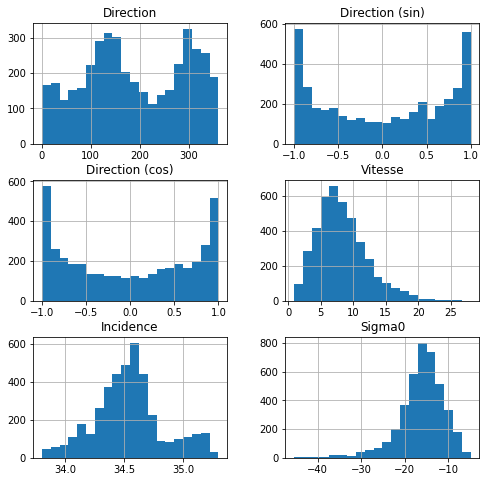

In [134]:
#ax = df.iloc[:,0].plot.hist(bins=12, alpha=0.5)
hist = df.hist(bins=20,figsize=(8,8))

In [135]:
#g = sns.pairplot(df, diag_kind="kde", markers="+",
#                  plot_kws=dict(s=50, edgecolor="b", linewidth=1),
#                  diag_kws=dict(shade=True))
#g = sns.PairGrid(df[['Direction','Vitesse','Incidence','Sigma0']], diag_sharey=False)
#g = sns.PairGrid(df(colums=['Direction','Direction (sin)','Direction (cos)','Vitesse','Incidence','Sigma0']), diag_sharey=False)
#g.map_lower(sns.kdeplot)
#g.map_upper(sns.scatterplot)
#g.map_diag(sns.kdeplot, lw=3)

In [136]:
if False:
    g = sns.PairGrid(df[['Direction','Direction (sin)','Direction (cos)','Sigma0']], diag_sharey=False)
    g.map_lower(sns.kdeplot)
    g.map_upper(sns.scatterplot)
    g.map_diag(sns.kdeplot, lw=3)

### Mise en forme et codages des entrées et des sorties du réseau de neurone

In [137]:
#
# moyennes et écarts types,
direction_moyenne = np.mean(direction)
direction_sin_moyenne = np.mean(direction_sin)
direction_cos_moyenne = np.mean(direction_cos)
vitesse_moyenne = np.mean(vitesse)
incidence_moyenne = np.mean(incidence)
sigma0_moyenne = np.mean(sigma0)

# ecart-types
direction_et = np.std(direction)
direction_sin_et = np.std(direction_sin)
direction_cos_et = np.std(direction_cos)
vitesse_et = np.std(vitesse);
incidence_et = np.std(incidence);
sigma0_et = np.std(sigma0)

#
# Donnees normalisees et matrice d'entree
DirN    = (direction - direction_moyenne ) /  direction_et  * 2/3
Dir_sinN    = (direction_sin - direction_sin_moyenne ) /  direction_sin_et  * 2/3
Dir_cosN    = (direction_cos - direction_cos_moyenne ) /  direction_cos_et  * 2/3
VitN    = (vitesse   - vitesse_moyenne   ) /  vitesse_et  * 2/3
IncN    = (incidence - incidence_moyenne ) / incidence_et * 2/3
SigN    = (sigma0    - sigma0_moyenne    ) / sigma0_et    * 2/3

#
XN      = np.concatenate((Dir_sinN,Dir_cosN,IncN, VitN), axis=1)

In [138]:
import math

def reverse_sin_cos(sin,cos):
    a_acos = np.arccos(cos)
    direction=[]
    for i,arcos in enumerate(a_acos):
        if sin[i] < 0:
           direction.append(math.degrees(-arcos) % 360)
        else: 
           direction.append(math.degrees(arcos))
    return np.array(direction)


def unormalize_cos(normalized_cos):
    return (3/2)*normalized_cos*direction_cos_et+direction_cos_moyenne
    
def unormalize_sin(normalized_sin):
    return (3/2)*normalized_sin*direction_sin_et+direction_sin_moyenne

def reverse_direction(sinN,cosN):
    cos =unormalize_cos(cosN)
    sin = unormalize_sin(sinN)
    return reverse_sin_cos(sin,cos)
    

In [139]:
reverse_sin_cos(direction_sin.squeeze(),direction_cos)

array([234.33, 281.33, 322.16, ...,  91.56, 321.35,  59.94])

In [140]:
reverse_direction(Dir_sinN,Dir_cosN)

array([234.33, 281.33, 322.16, ...,  91.56, 321.35,  59.94])

In [141]:
def unromalize_speed(speedN):
    return vitesse_et*speedN*3/2 + vitesse_moyenne


In [142]:
unromalize_speed(VitN)

array([[11.12],
       [ 5.54],
       [ 4.95],
       ...,
       [ 8.93],
       [ 7.65],
       [16.95]])

In [143]:
# pour la suite, on cree des intervalles reguliers en vitesse et direction 
vit_grid = np.linspace(vitesse.min(),vitesse.max(),10)
vitN_grid = (vit_grid   - vitesse_moyenne   ) /  vitesse_et  * 2/3

dir_grid  = np.linspace(direction.min(),direction.max(),100)
dirN_grid = (dir_grid - direction_moyenne ) /  direction_et  * 2/3
dir_sin_grid  = np.sin(dir_grid/180*np.pi)
dir_sinN_grid = (dir_sin_grid - direction_sin_moyenne ) /  direction_sin_et  * 2/3
dir_cos_grid  = np.cos(dir_grid/180*np.pi)
dir_cosN_grid = (dir_cos_grid - direction_cos_moyenne ) /  direction_cos_et  * 2/3

inc_grid = np.linspace(incidence.min(),incidence.max(),100)
incN_grid = (inc_grid   - incidence_moyenne   ) /  incidence_et  * 2/3

## 1 ère Partie : Modélisation du diffusiomètre NSCAT

Nous vous demandons de réaliser une régression par PMC pour modéliser la fonction du
diffusiomètre NSCAT. Le rôle du PMC sera donc de donner la valeur de sortie Sigma0 en fonction
de la direction et de la vitesse du vent.

In [144]:
import torch

In [145]:
from sklearn.model_selection import train_test_split

X_train, X_test, SigN_train, SigN_test,DirNTrain,_,VitNTrain,_,Dir_sinNTrain,_,Dir_cosNTrain,_ = train_test_split(XN, SigN,DirN,VitN,Dir_sinN,Dir_cosN, test_size=0.33)

In [146]:
df_train = pd.DataFrame(X_train)
df_train.columns = ['DirSinN','DirCosN','VitesN','INCN']
df_train['Sigma0'] = SigN_train


#g = sns.PairGrid(df_train,diag_sharey=False)
#g.map_lower(sns.kdeplot)
#g.map_upper(sns.scatterplot)
#g.map_diag(sns.kdeplot, lw=3)

In [147]:
import plotly.express as px
df = px.data.tips()
fig = px.box(df_train)
fig.show()

### Apprentissage du mlp

In [148]:
'''from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {"activation": Categorical(['tanh', 'relu']), 
        "solver": Categorical(['lbfgs', 'adam','sgd']),
        "hidden_layer_sizes": Integer(2,5),
    }

def on_step(optim_result):
    """
    Callback meant to view scores after
    each iteration while performing Bayesian
    Optimization in Skopt"""
    score = forest_bayes_search.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True

regressor = MLPRegressor(early_stopping=True,learning_rate = 'adaptive',max_iter=100000)
forest_bayes_search = BayesSearchCV(regressor, search_space, n_iter=32, n_jobs=-1, cv=5)

forest_bayes_search.fit(X_train, SigN_train.ravel(), callback=on_step) # callback=on_step will print score after each iteration'''

'from skopt import BayesSearchCV\nfrom skopt.space import Real, Categorical, Integer\n\nsearch_space = {"activation": Categorical([\'tanh\', \'relu\']), \n        "solver": Categorical([\'lbfgs\', \'adam\',\'sgd\']),\n        "hidden_layer_sizes": Integer(2,5),\n    }\n\ndef on_step(optim_result):\n    """\n    Callback meant to view scores after\n    each iteration while performing Bayesian\n    Optimization in Skopt"""\n    score = forest_bayes_search.best_score_\n    print("best score: %s" % score)\n    if score >= 0.98:\n        print(\'Interrupting!\')\n        return True\n\nregressor = MLPRegressor(early_stopping=True,learning_rate = \'adaptive\',max_iter=100000)\nforest_bayes_search = BayesSearchCV(regressor, search_space, n_iter=32, n_jobs=-1, cv=5)\n\nforest_bayes_search.fit(X_train, SigN_train.ravel(), callback=on_step) # callback=on_step will print score after each iteration'

In [243]:
forest_bayes_search.best_params_

OrderedDict([('activation', 'tanh'),
             ('hidden_layer_sizes', 3),
             ('solver', 'lbfgs')])

In [170]:
n_hidden = (3,)
#specification du modele
rgrsr_esperance = MLPRegressor(activation='tanh', hidden_layer_sizes = n_hidden, 
                     warm_start='True',solver='sgd', 
                     early_stopping=True, 
                     learning_rate = 'adaptive',max_iter=1000)
rgrsr_esperance.fit(X_train, SigN_train.ravel())
YN = rgrsr_esperance.predict(X_train)
Y = YN * 3/2 * sigma0_et + sigma0_moyenne

In [171]:
from sklearn.metrics import r2_score
r2_score(SigN_train.ravel(),YN)

0.6820934814697399

In [347]:
import torch
from torch.autograd import Variable
from torch.nn import Tanh

class linearRegression(torch.nn.Module):
    def __init__(self,):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(4, 5)
        self.activation = Tanh()
        self.output = torch.nn.Linear(5, 1)

    def forward(self, x):
        layer1 = self.linear(x)
        act = self.activation(layer1)
        out = self.output(act)
        return out

In [348]:
class My_Loss(torch.nn.Module):
    def __init__(self):
        super(My_Loss, self).__init__()
    def forward(self, input, target):
        #print(input.shape)
        return torch.mean((1/(target[:,1].reshape(-1,1)))*(input - target[:,0].reshape(-1,1))**2)

In [349]:
SigN.shape

(4098, 1)

In [374]:
from skorch import NeuralNetRegressor
import torch

net = NeuralNetRegressor(
    linearRegression,
    max_epochs=300,
    lr = 0.1,
    iterator_train__shuffle=True,
    # Shuffle training data on each epoch
    optimizer=torch.optim.Adam,
    verbose=0,
)

#net.fit(XN.astype(np.float32), np.concatenate((SigN,vitesse),axis=1).astype(np.float32))
net.fit(XN.astype(np.float32), SigN.astype(np.float32))

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=linearRegression(
    (linear): Linear(in_features=4, out_features=5, bias=True)
    (activation): Tanh()
    (output): Linear(in_features=5, out_features=1, bias=True)
  ),
)

In [375]:
SigN.astype(np.float32).reshape(-1,1).shape

(4098, 1)

In [376]:
net.predict(XN.astype(np.float32)).ravel()

array([ 0.26716828, -0.3729555 , -0.36956462, ...,  0.07101095,
        0.01644856,  0.9709022 ], dtype=float32)

In [377]:
np.expand_dims(SigN,axis=1).astype(np.float32).ravel()

array([ 0.33311042, -0.37182894,  0.02065081, ..., -0.14447013,
        0.14893708,  1.0494813 ], dtype=float32)

In [378]:
from sklearn.metrics import r2_score
r2_score(np.expand_dims(SigN,axis=1).astype(np.float32).ravel(),net.predict(XN.astype(np.float32)).ravel() )

0.7004375827886751

In [379]:
def reverse_sigamo(sigamoN):
    return sigamoN * 3/2 * sigma0_et + sigma0_moyenne

In [380]:
rgrsr_esperance.score(X_train, SigN_train.ravel())

0.6820934814697399

In [163]:
rgrsr_esperance.score(X_test, SigN_test.ravel())

0.6832840518321652

In [252]:
#np.logical_and(33.5<=reverse_direction(X_train[:,0],X_train[:,1]),reverse_direction(X_train[:,0],X_train[:,1])<=35.5).sum()

In [253]:
reverse_direction(X_train[:,0],X_train[:,1])

array([140.1 , 271.65, 322.  , ..., 331.19, 101.22, 330.49])

In [254]:
df_train['unormalized_direction'] = reverse_direction(X_train[:,0],X_train[:,1])
df_train['unromalized_speed'] = unromalize_speed(X_train[:,2])

In [255]:
L =[g.reset_index(drop=True) for i, g in df_train.groupby([df_train.unormalized_direction//60])]
intervals = list()
for l in L: 
    intervals.append([g.reset_index(drop=True) for i, g in l.groupby([l.unromalized_speed//2])])

In [263]:
v_range

,DirSinN,DirCosN,VitesN,INCN,Sigma0,unormalized_direction,unromalized_speed
0,-0.297705,0.913871,1.675334,-0.868903,-0.627131,342.15,18.002623
1,-0.142564,0.949974,1.675334,-0.853392,-0.539490,351.88,18.002623


In [261]:
import plotly.graph_objects as go
fig = go.Figure()

for i,angle_range in enumerate(intervals): 
    speed = np.arange(len(angle_range),step=2)
    scores = []
    for v_range in  angle_range:
        scores.append(rgrsr_esperance.score(v_range.iloc[:,:4].values,v_range.iloc[:,4]))
    fig.add_trace(go.Scatter(x=speed, y=scores,mode='lines',name=i*60))

fig.update_layout(
    title="R1 Score en fonction de la vitesse et direction",
    xaxis_title="Direction",
    yaxis_title="R1 Score",
)
fig.show()


In [264]:
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error

fig = go.Figure()

for i,angle_range in enumerate(intervals): 
    speed = np.arange(len(angle_range),step=2)
    scores = []
    for v_range in  angle_range:
        scores.append(np.sqrt(mean_squared_error(rgrsr_esperance.predict(v_range.iloc[:,:4].values),v_range.iloc[:,4])))
    fig.add_trace(go.Scatter(x=speed, y=scores,mode='lines',name="intervalle [{},{}]".format(i*60,(i+1)*60)))

fig.update_layout(
    title="RMS Score en fonction de la vitesse et direction",
    xaxis_title="Vitesse",
    yaxis_title="RMS Score",
)
fig.show()


In [265]:
def rms_relatif(pred,excat):
    return np.sqrt(np.mean(((reverse_sigamo(excat)-reverse_sigamo(pred))/reverse_sigamo(excat))**2))

In [266]:
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error

fig = go.Figure()

for i,angle_range in enumerate(intervals): 
    speed = np.arange(len(angle_range),step=2)
    scores = []
    for v_range in  angle_range:
        scores.append(rms_relatif(rgrsr_esperance.predict(v_range.iloc[:,:4].values),v_range.iloc[:,4]))
    fig.add_trace(go.Scatter(x=speed, y=scores,mode='lines',name="intervalle [{},{}]".format(i*60,(i+1)*60)))

fig.update_layout(
    title="RMS relatif Score en fonction de la vitesse et direction",
    xaxis_title="Vitesse",
    yaxis_title="RMS relatif Score",
)
fig.show()


In [267]:
def bias(pred,excat):
    return np.mean(excat-pred)

In [268]:
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error

fig = go.Figure()

for i,angle_range in enumerate(intervals): 
    speed = np.arange(len(angle_range),step=2)
    scores = []
    for v_range in  angle_range:
        scores.append(bias(rgrsr_esperance.predict(v_range.iloc[:,:4].values),v_range.iloc[:,4]))
    fig.add_trace(go.Scatter(x=speed, y=scores,mode='lines',name="intervalle [{},{}]".format(i*60,(i+1)*60)))

fig.update_layout(
    title="Bias  Score en fonction de la vitesse et direction",
    xaxis_title="Vitesse",
    yaxis_title="Bias Score",
)
fig.show()


In [269]:
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error

fig = go.Figure()

for i,angle_range in enumerate(intervals): 
    speed = np.arange(len(angle_range),step=2)
    scores = []
    for v_range in  angle_range:
        scores.append(len(v_range))
    fig.add_trace(go.Scatter(x=speed, y=scores,mode='lines',name="intervalle [{},{}]".format(i*60,(i+1)*60)))

fig.update_layout(
    title="Nombre de points Score en fonction de la vitesse et direction",
    xaxis_title="Vitesse",
    yaxis_title="Nombre de points",
)
fig.show()


In [270]:
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error

fig = go.Figure()

for i,angle_range in enumerate(intervals): 
    speed = np.arange(len(angle_range),step=2)
    scores = []
    for v_range in  angle_range:
        scores.append(np.mean(v_range.iloc[:,3]))
    fig.add_trace(go.Scatter(x=speed, y=scores,mode='lines',name="intervalle [{},{}]".format(i*60,(i+1)*60)))

fig.update_layout(
    title="Valeur moyenne des vitesse",
    xaxis_title="Vitesse",
    yaxis_title="Valeurs moyenne normalisé",
)
fig.show()


In [271]:
df_train.groupby((df_train.unormalized_direction//60),
           as_index=False).apply(pd.DataFrame.reset_index, drop=True)

DirSinN   DirCosN    VitesN      INCN    Sigma0  \
0 0    0.706009  0.624755 -0.913448 -0.010634  0.359784   
  1    0.414846  0.856898  1.337666  0.251327  0.353433   
  2    0.300877  0.906016  0.077042 -0.146785 -0.274027   
  3    0.450238  0.837799  0.752377 -0.562132 -0.031426   
  4    0.136695  0.947834  0.324665  0.418500  0.841175   
...         ...       ...       ...       ...       ...   
5 572 -0.368130  0.887806 -0.013002  1.540454  1.204441   
  573 -0.692099  0.662935  1.360177 -0.401853 -0.387071   
  574 -0.721290  0.630286  1.585289  0.654610  0.394078   
  575 -0.462327  0.842219 -0.328158 -0.934393 -1.348583   
  576 -0.472341  0.836580  0.324665  0.287519  0.733211   

       unormalized_direction  unromalized_speed  
0 0                    49.71           2.981531  
  1                    26.91          16.043350  
  2                    19.34           8.728731  
  3                    29.36          12.647277  
  4                     8.99          10.165531  
...                      ...                ...  
5 572                 337.57           8.206258  
  573                 313.39          16.173968  
  574                 310.73          17.480150  
  575                 331.19           6.377604  
  576                 330.49          10.165531  

[2745 rows x 7 columns]

In [272]:
df_train

,DirSinN,DirCosN,VitesN,INCN,Sigma0,unormalized_direction,unromalized_speed
0,0.592120,-0.714533,-0.530759,0.244434,0.348352,140.10,5.202040
1,-0.948250,0.039465,1.315155,-0.122657,-0.266406,271.65,15.912732
2,-0.587877,0.758657,-0.373181,-0.570749,-0.327373,322.00,6.116367
3,-0.461609,-0.818239,-0.508248,-0.043379,0.420752,208.76,5.332658
4,0.901229,0.239592,0.099553,-0.720688,-2.487917,76.11,8.859349
...,...,...,...,...,...,...,...
2740,0.826963,-0.416689,0.504754,0.172050,-0.117797,116.92,11.210477
2741,0.491316,0.813067,0.032020,-0.432875,0.242929,32.28,8.467495
2742,-0.462327,0.842219,-0.328158,-0.934393,-1.348583,331.19,6.377604
2743,0.910736,-0.172130,-0.575781,2.078164,0.942788,101.22,4.940803


### Visualisation et affichage de la fonction estimée

#### Quelques fonctions

In [109]:
def tracerLesDonneesEnCouleur(x,y,c,nombreDeClasses = 100,cb_label=''):
    classes_edges = np.linspace(c.min(),c.max(),nombreDeClasses)
    classes_edges[0] , classes_edges[-1] = -np.infty, np.infty
    classes_indices = np.digitize(c,classes_edges)

    cmap = matplotlib.cm.hot
    cmap = matplotlib.cm.jet
    norm = matplotlib.cm.colors.Normalize(vmin=c.min(), vmax=c.max())
    colors = cmap(np.linspace(0,1,nombreDeClasses))
    for k in range(nombreDeClasses): # boucle sur les mois
        selec_classes = np.where(classes_indices==k)
        if len(selec_classes[0]) != 0:
            h = plt.plot(x[selec_classes], y[selec_classes[0]],'.', color=colors[k])

            
    ax = plt.gca()
    pos1 = ax.get_position() # get the original position 
    if False:
        pos2 = [pos1.x0, pos1.y0+pos1.height*.125,  pos1.width , pos1.height*.85] 
        pos3 = [pos1.x0, pos1.y0,  pos1.width , pos1.height*.025] 
        orientation='horizontal'
    else:
        pos2 = [pos1.x0, pos1.y0,  pos1.width*.825 , pos1.height] 
        pos3 = [pos1.x0+pos1.width*.85, pos1.y0,  pos1.width*.025 , pos1.height] 
        orientation='vertical'
            
    ax.set_position(pos2) #
    ax_cb = fig.add_axes(pos3)    
    cb = matplotlib.colorbar.ColorbarBase(ax_cb,cmap=cmap,
                                          norm=norm, 
                                          orientation=orientation)
    #cb.set_label(cb_label)
    cb.ax.get_yaxis().labelpad = 15
    cb.ax.set_ylabel(cb_label, rotation=270)

    plt.sca(ax)
    
    return colors, classes_edges 

#### Affichage de la fonction estimée avec une entrée connue

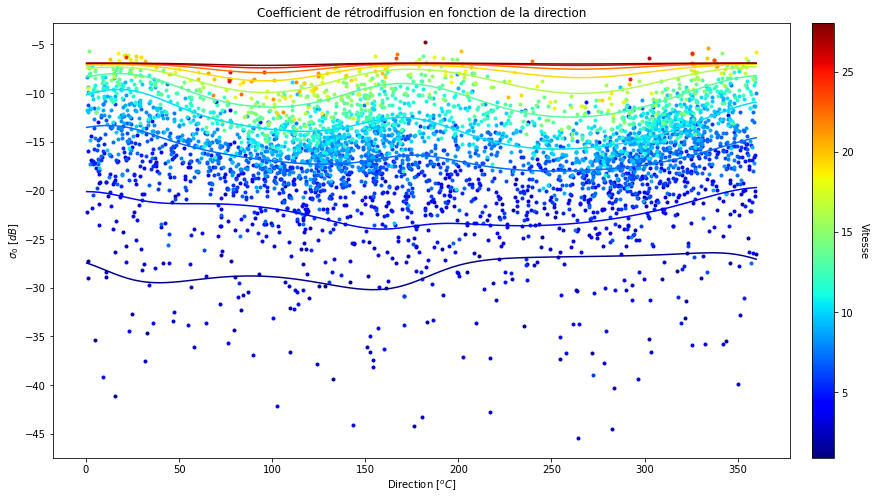

In [381]:
fig, ax = plt.subplots(1,figsize=(16,8))
colors, classes_edges = tracerLesDonneesEnCouleur(direction,sigma0,vitesse,nombreDeClasses = 100,cb_label="Vitesse")

classes_regr_indices = np.digitize(vit_grid,classes_edges)
for v,k in zip(vitN_grid,classes_regr_indices):
    xN_tmp = np.concatenate((dir_sinN_grid[:,None],dir_cosN_grid[:,None],incN_grid[:,None], v*np.ones(dirN_grid.shape)[:,None]), axis=1)
    yN_tmp = net.predict(xN_tmp.astype(np.float32))
    #yN_tmp = np.expand_dims(yN_tmp, axis=1)
    y_tmp = yN_tmp* 3/2 * sigma0_et + sigma0_moyenne
    plt.plot(dir_grid,y_tmp,color=colors[k])

plt.title("Coefficient de rétrodiffusion en fonction de la direction")
plt.ylabel("$\sigma_0$ [$dB$]")
plt.xlabel("Direction [$^oC$]") ;

$RMS=\displaystyle\sqrt{\frac{1}{n}\sum_{i=1}^n(x_i^\text{ref}-x_i^\text{ext})^2}$
$RMS_\text{relative}=\displaystyle\sqrt{\frac{1}{n}\sum_{i=1}^n(\frac{x_i^\text{ref}-x_i^\text{ext}}{x_i^\text{ref}})^2}$
$Bias=\displaystyle\frac{1}{n}\sum_{i=1}^n(x_i^\text{ref}-x_i^\text{ext})$

Text(0.5, 0, 'Direction normalisée []')

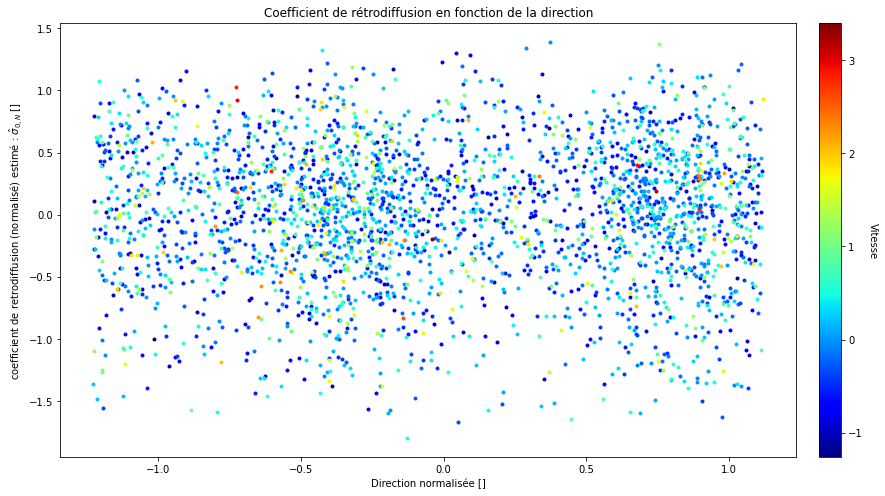

In [306]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

tracerLesDonneesEnCouleur(DirNTrain,YN,VitNTrain,nombreDeClasses = 100,cb_label="Vitesse")
plt.title("Coefficient de rétrodiffusion en fonction de la direction")
plt.ylabel("coefficient de retrodiffusion (normalisé) estimé : $\hat{\sigma}_{0,N}$ []")
plt.xlabel("Direction normalisée []")

#### Affichage du diagramme de dispersion

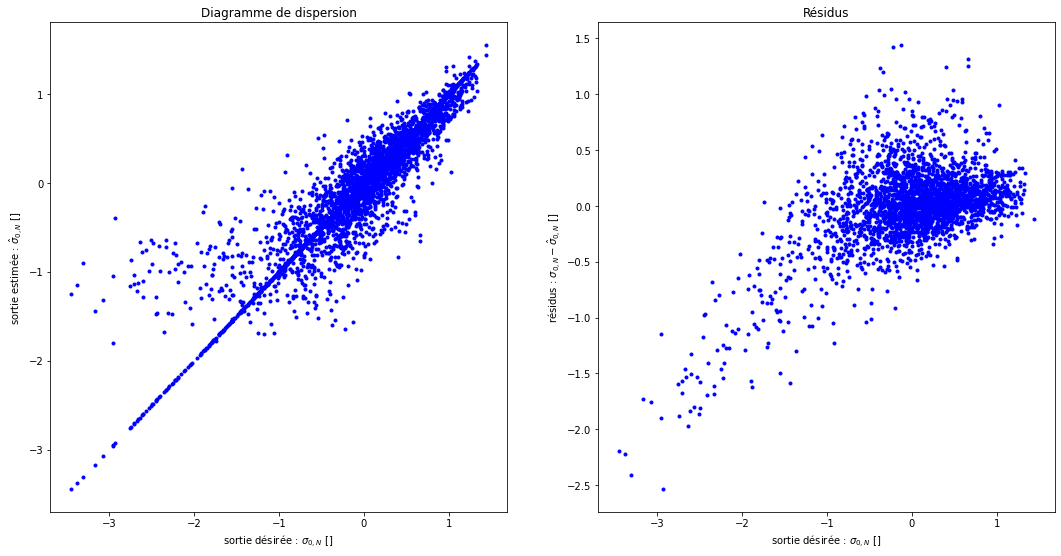

In [280]:
plt.figure(figsize=(18,9))
plt.subplot(1,2,1)
plt.plot(SigN_train,YN,'.b')
plt.plot(SigN_train,SigN_train,'.b')

plt.title("Diagramme de dispersion")
plt.ylabel("sortie estimée : $\hat{\sigma}_{0,N}$ []")
plt.xlabel("sortie désirée : $\sigma_{0,N}$ []")
plt.subplot(1,2,2)
plt.plot(SigN_train,SigN_train-YN[:,None],'.b')
plt.title("Résidus")
plt.xlabel("sortie désirée : $\sigma_{0,N}$ []")
plt.ylabel("résidus : $\sigma_{0,N}-\hat{\sigma}_{0,N}$ []") ;


#### Affichage des diagrammes de dispersion (avec informations supplémentaires sur les entrées)

/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



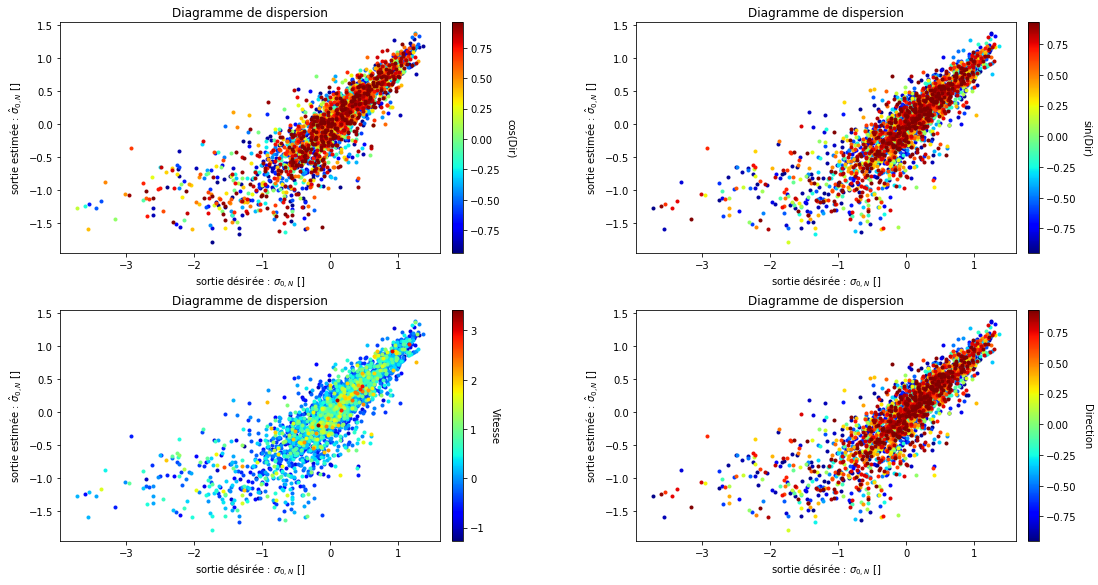

In [345]:
fig = plt.figure(figsize=(16,8))
ax = [ [fig.add_axes((.05,.05,.4,.4)),fig.add_axes((.55,.05,.4,.4))],
       [fig.add_axes((.05,.55,.4,.4)),fig.add_axes((.55,.55,.4,.4))] ]

#plt.subplot(2,2,1)
plt.sca(ax[0][0])
tracerLesDonneesEnCouleur(SigN,YN,VitNTrain,nombreDeClasses = 100,cb_label="Vitesse")
plt.title("Diagramme de dispersion")
plt.ylabel("sortie estimée : $\hat{\sigma}_{0,N}$ []")
plt.xlabel("sortie désirée : $\sigma_{0,N}$ []")
#plt.subplot(2,2,2)
plt.sca(ax[0][1])
tracerLesDonneesEnCouleur(SigN,YN,Dir_sinNTrain,nombreDeClasses = 100,cb_label="Direction")
plt.title("Diagramme de dispersion")
plt.ylabel("sortie estimée : $\hat{\sigma}_{0,N}$ []")
plt.xlabel("sortie désirée : $\sigma_{0,N}$ []")
plt.tight_layout()
#plt.subplot(2,2,3)
plt.sca(ax[1][0])
tracerLesDonneesEnCouleur(SigN,YN,Dir_cosNTrain,nombreDeClasses = 100,cb_label="cos(Dir)")
plt.title("Diagramme de dispersion")
plt.ylabel("sortie estimée : $\hat{\sigma}_{0,N}$ []")
plt.xlabel("sortie désirée : $\sigma_{0,N}$ []")
#plt.subplot(2,2,4)
plt.sca(ax[1][1])
tracerLesDonneesEnCouleur(SigN,YN,Dir_sinNTrain,nombreDeClasses = 100,cb_label="sin(Dir)")
plt.title("Diagramme de dispersion")
plt.ylabel("sortie estimée : $\hat{\sigma}_{0,N}$ []")
plt.xlabel("sortie désirée : $\sigma_{0,N}$ []") ;

#plt.tight_layout() 

#### Affichage des Résidus en fonction de la direction

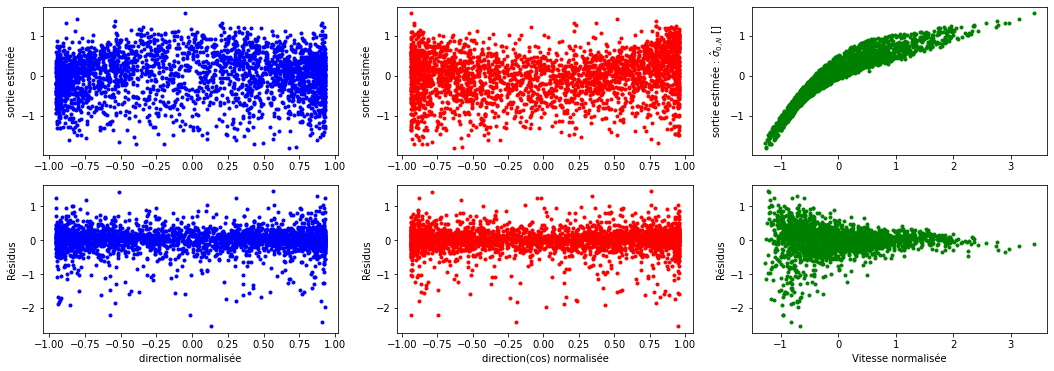

In [282]:
plt.figure(figsize=(18,6))
#
plt.subplot(2,3,1)
plt.plot(Dir_sinNTrain,YN[:,None],'.b')
plt.ylabel("sortie estimée")
plt.subplot(2,3,4)
plt.plot(Dir_sinNTrain,SigN_train-YN[:,None],'.b')
plt.ylabel("Résidus")
plt.xlabel("direction normalisée")
#
plt.subplot(2,3,2)
plt.plot(Dir_cosNTrain,YN[:,None],'.r')
plt.ylabel("sortie estimée")
plt.subplot(2,3,5)
plt.plot(Dir_cosNTrain,SigN_train-YN[:,None],'.r')
plt.ylabel("Résidus")
plt.xlabel("direction(cos) normalisée")
#
plt.subplot(2,3,3)
plt.plot(VitNTrain,YN[:,None],'.g')
plt.ylabel("sortie estimée : $\hat{\sigma}_{0,N}$ []")
plt.subplot(2,3,6)
plt.plot(VitNTrain,SigN_train-YN[:,None],'.g')
plt.ylabel("Résidus")
plt.xlabel("Vitesse normalisée") ;
#


## 2 ème Partie : Encadrement par approximation de la variance

Afin d’attacher des intervalles de confiance aux résultats trouvés, on propose d’estimer la
variance du bruit en fonction des données. La méthode proposée a déjà été mise en œuvre dans un
TP précédent.

In [318]:
n_hidden = (4,)
# specification du modele
rgrsr = MLPRegressor(activation='tanh', hidden_layer_sizes = n_hidden, 
                     warm_start='True',solver='lbfgs', 
                     early_stopping=True, 
                     learning_rate = 'adaptive',max_iter=100000)
rgrsr= rgrsr_esperance.fit(XN, SigN.ravel())
YN = rgrsr.predict(XN)
Y = YN * 3/2 * sigma0_et + sigma0_moyenne
Sig = SigN * 3/2 * sigma0_et + sigma0_moyenne

In [319]:
((YN-SigN.squeeze())**2).mean()

0.12844087992952566

In [320]:
variance_app = (Y.squeeze()-Sig.squeeze())**2
moy_variance = np.mean(variance_app)
ect_variance = np.std(variance_app)
variance_appN = (variance_app - moy_variance)/ect_variance*2/3

Text(0, 0.5, 'sortie estimée : $\\hat{\\sigma}_{0,N}$ []')

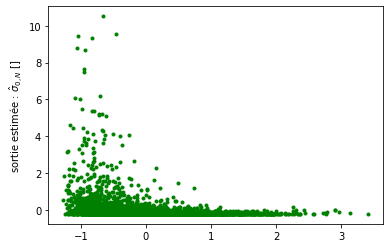

In [329]:
plt.plot(VitN,variance_appN,'.g')
plt.ylabel("sortie estimée : $\hat{\sigma}_{0,N}$ []")

Text(0, 0.5, 'sortie estimée : $\\hat{\\sigma}_{0,N}$ []')

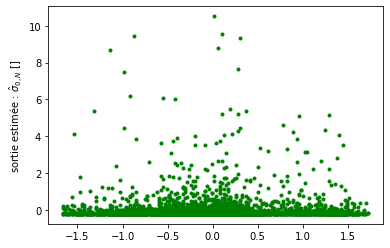

In [331]:
plt.plot(IncN,variance_appN,'.g')
plt.ylabel("sortie estimée : $\hat{\sigma}_{0,N}$ []")

In [287]:
variance_appN.mean()

-3.4677537128360186e-18

In [289]:
df_part2 = pd.DataFrame(XN)
df_part2.columns = ['DirSinN','DirCosN','VitesN','INCN']
df_part2['variance'] = variance_appN

In [290]:
df_part2.corr()

,DirSinN,DirCosN,VitesN,INCN,variance
DirSinN,1.000000,-0.214886,-0.174956,0.067687,-0.023167
DirCosN,-0.214886,1.000000,0.065495,-0.010067,0.007771
VitesN,-0.174956,0.065495,1.000000,-0.115581,0.008409
INCN,0.067687,-0.010067,-0.115581,1.000000,-0.257803
variance,-0.023167,0.007771,0.008409,-0.257803,1.000000


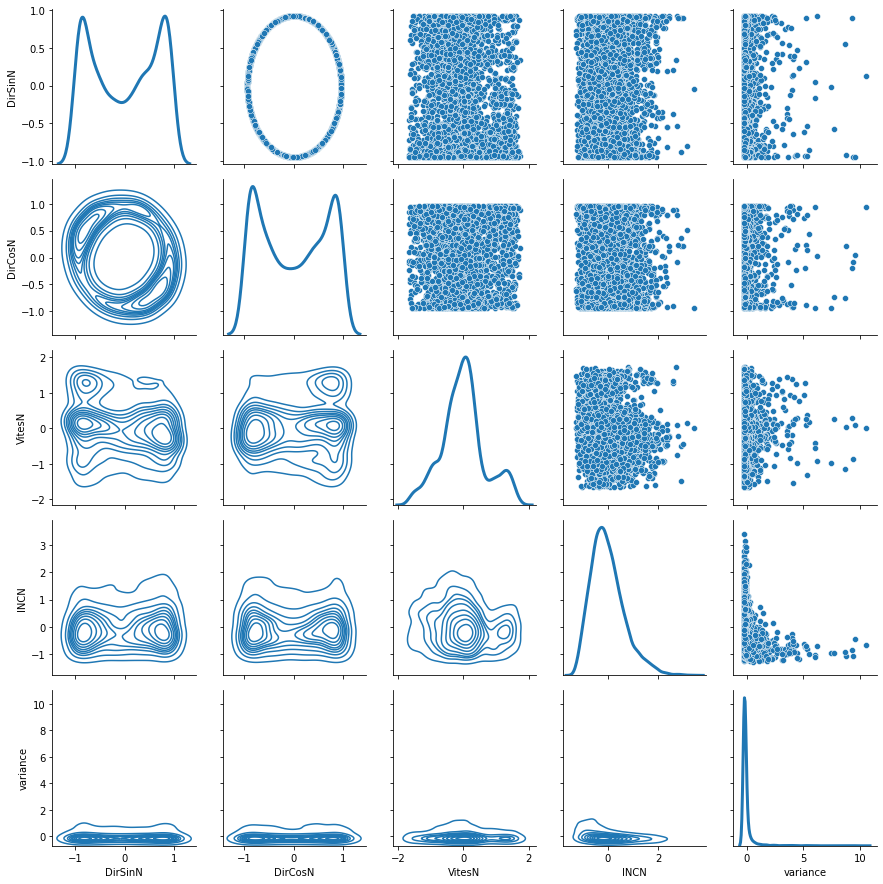

In [291]:
g = sns.PairGrid(df_part2,diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3)

In [292]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {"activation": Categorical(['tanh', 'relu']), 
        "solver": Categorical(['lbfgs', 'adam','sgd']),
        "hidden_layer_sizes": Integer(2, 4),
    }

def on_step(optim_result):
    """
    Callback meant to view scores after
    each iteration while performing Bayesian
    Optimization in Skopt"""
    score = forest_bayes_search.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True

regressor = MLPRegressor(early_stopping=True,learning_rate = 'adaptive',max_iter=100000)
forest_bayes_search = BayesSearchCV(regressor, search_space, n_iter=32, n_jobs=-1, cv=5)

forest_bayes_search.fit(XN, variance_appN, callback=on_step) # callback=on_step will print score after each iteration

best score: 0.0840488239907905
best score: 0.0840488239907905
best score: 0.11771937470470105
best score: 0.11771937470470105
best score: 0.11804205198369067
best score: 0.11804205198369067
best score: 0.11804205198369067
best score: 0.11804205198369067
best score: 0.11804205198369067
best score: 0.11804205198369067
best score: 0.11804205198369067
best score: 0.11804205198369067
best score: 0.11804205198369067
best score: 0.11905210952311077
best score: 0.11905210952311077
best score: 0.11905210952311077


/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



best score: 0.11905210952311077


/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



best score: 0.11905210952311077
best score: 0.11905210952311077
best score: 0.11905210952311077


/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



best score: 0.11905210952311077


/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



best score: 0.11905210952311077
best score: 0.11905210952311077


/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



best score: 0.11941173633492783


/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



best score: 0.11941173633492783


/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



best score: 0.11941173633492783


/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



best score: 0.11941173633492783


/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



best score: 0.11941173633492783


/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



best score: 0.11941173633492783


/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



best score: 0.11941173633492783


/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



best score: 0.11941173633492783


/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



best score: 0.11941173633492783


BayesSearchCV(cv=5,
              estimator=MLPRegressor(early_stopping=True,
                                     learning_rate='adaptive',
                                     max_iter=100000),
              n_iter=32, n_jobs=-1,
              search_spaces={'activation': Categorical(categories=('tanh', 'relu'), prior=None),
                             'hidden_layer_sizes': Integer(low=2, high=4, prior='uniform', transform='identity'),
                             'solver': Categorical(categories=('lbfgs', 'adam', 'sgd'), prior=None)})

In [293]:
forest_bayes_search.score(XN,variance_appN)

0.1324969023105066

In [294]:
forest_bayes_search.best_estimator_

MLPRegressor(early_stopping=True, hidden_layer_sizes=2,
             learning_rate='adaptive', max_iter=100000, solver='lbfgs')

In [340]:
n_hidden = (2,)
# specification du modele
rgrsr2 = MLPRegressor(activation='tanh', hidden_layer_sizes = n_hidden, 
                     warm_start='True',solver='lbfgs', 
                     early_stopping=True, 
                     learning_rate = 'adaptive',max_iter=100000)
rgrsr2.fit(XN, variance_appN)

MLPRegressor(activation='tanh', early_stopping=True, hidden_layer_sizes=(2,),
             learning_rate='adaptive', max_iter=100000, solver='lbfgs',
             warm_start='True')

In [341]:
rgrsr2.score(XN, variance_appN)

0.13648593663594588

[       -inf  3.94333333  6.95666667  9.97       12.98333333 15.99666667
 19.01       22.02333333 25.03666667         inf]


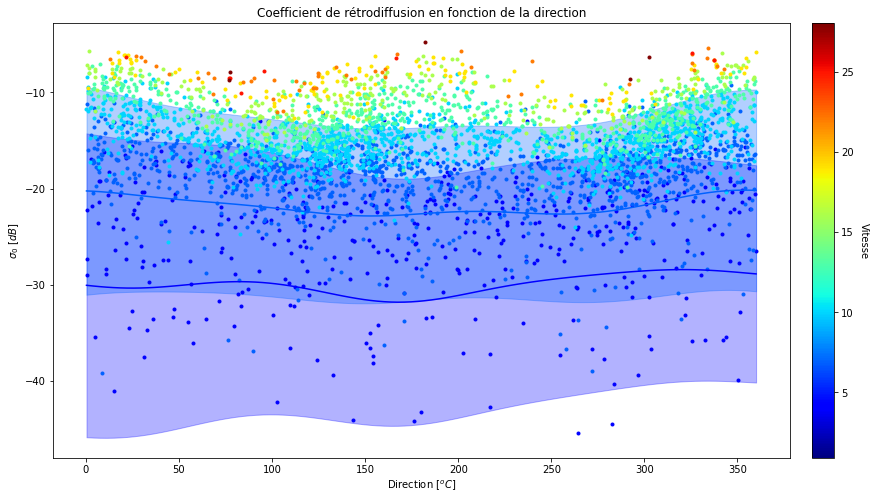

In [344]:
fig, ax = plt.subplots(1,figsize=(16,8))
colors, classes_edges = tracerLesDonneesEnCouleur(direction,sigma0,vitesse,nombreDeClasses = 10,cb_label="Vitesse")
print(classes_edges)
classes_regr_indices = np.digitize(vit_grid,classes_edges)
for i,(v,k) in enumerate(zip(vitN_grid,classes_regr_indices)):
    xN_tmp = np.concatenate((dir_sinN_grid[:,None],dir_cosN_grid[:,None],incN_grid[:,None], v*np.ones(dirN_grid.shape)[:,None]), axis=1)
    yN_tmp = rgrsr_esperance.predict(xN_tmp)
    yN_tmp = np.expand_dims(yN_tmp, axis=1)
    y_tmp = yN_tmp* 3/2 * sigma0_et + sigma0_moyenne
    if (i==1 or i==0):
        noise = rgrsr2.predict(xN_tmp)*ect_variance*3/2 + moy_variance
        plt.plot(dir_grid,y_tmp,color=colors[k])
        ax.fill_between(dir_grid, y_tmp.reshape(-1)+2*np.sqrt(noise),y_tmp.reshape(-1) -2*np.sqrt(noise) , color=colors[k], alpha=.3)

plt.title("Coefficient de rétrodiffusion en fonction de la direction")
plt.ylabel("$\sigma_0$ [$dB$]")
plt.xlabel("Direction [$^oC$]") ;

In [202]:
df_part2['unormalized_direction'] = reverse_direction(XN[:,0],XN[:,1])
df_part2['unromalized_speed'] = unromalize_speed(XN[:,2])

In [61]:
L =[g.reset_index(drop=True) for i, g in df_part2.groupby([df_part2.unormalized_direction//60])]
intervals = list()
for l in L: 
    intervals.append([g.reset_index(drop=True) for i, g in l.groupby([l.unromalized_speed//2])])

In [62]:
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error

fig = go.Figure()

for i,angle_range in enumerate(intervals): 
    speed = np.arange(len(angle_range),step=2)
    scores = []
    for v_range in  angle_range:
        scores.append(np.sqrt(mean_squared_error(rgrsr2.predict(v_range.iloc[:,:3].values),v_range.iloc[:,3])))
    fig.add_trace(go.Scatter(x=speed, y=scores,mode='lines',name="intervalle [{},{}]".format(i*60,(i+1)*60)))

fig.update_layout(
    title="RMS Score en fonction de la vitesse et direction",
    xaxis_title="Vitesse",
    yaxis_title="RMS Score",
)
fig.show()


In [396]:
import torch
from torch.autograd import Variable
from torch.nn import ReLU,

class linearRegression(torch.nn.Module):
    def __init__(self,):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(4, 5)
        self.activation = ReLU()
        self.output = torch.nn.Linear(5, 1)

    def forward(self, x):
        layer1 = self.linear(x)
        act = self.activation(layer1)
        out = self.output(act)
        return out

In [397]:
from skorch import NeuralNetRegressor

In [398]:
net = NeuralNetRegressor(
    linearRegression,
    max_epochs=100,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

net.fit(XN.astype(np.float32), np.expand_dims(variance_appN,axis=1).astype(np.float32))

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.4012        0.5568  0.2468
      2        0.3918        0.5534  0.1163
      3        0.3894        0.5501  0.1245
      4        0.3880        0.5476  0.1022
      5        0.3869        0.5455  0.1260
      6        0.3861        0.5478  0.1333
      7        0.3851        0.5458  0.1543
      8        0.3846        0.5439  0.1721
      9        0.3842        0.5442  0.1344
     10        0.3834        0.5417  0.1107
     11        0.3828        0.5478  0.1122
     12        0.3827        0.5375  0.1147
     13        0.3816        0.5375  0.1174
     14        0.3807        0.5401  0.1119
     15        0.3794        0.5392  0.1150
     16        0.3781        0.5308  0.1292
     17        0.3768        0.5335  0.1971
     18        0.3755        0.5317  0.1378
     19        0.3744        0.5283  0.1100
     20        0.3732        0.5231  0.1106
     21        0.3715        0.5

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=linearRegression(
    (linear): Linear(in_features=4, out_features=5, bias=True)
    (activation): ReLU()
    (output): Linear(in_features=5, out_features=1, bias=True)
  ),
)

[       -inf  3.94333333  6.95666667  9.97       12.98333333 15.99666667
 19.01       22.02333333 25.03666667         inf]


NameError: name 'ect_variance' is not defined

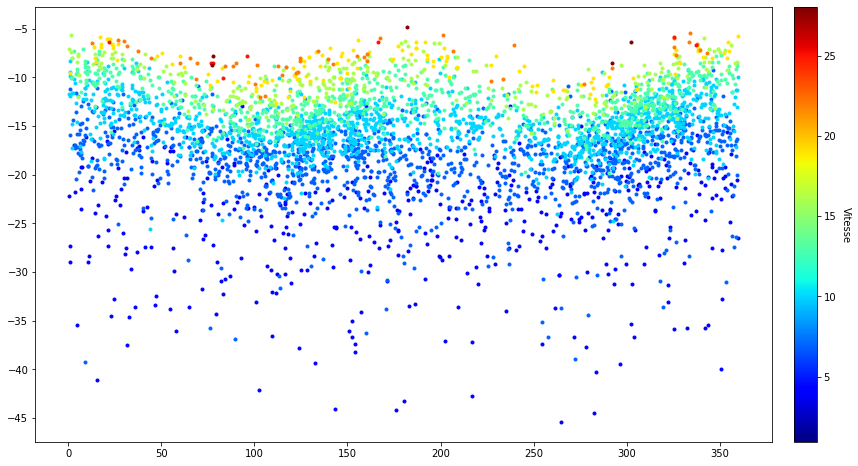

In [382]:
fig, ax = plt.subplots(1,figsize=(16,8))
colors, classes_edges = tracerLesDonneesEnCouleur(direction,sigma0,vitesse,nombreDeClasses = 10,cb_label="Vitesse")
print(classes_edges)
classes_regr_indices = np.digitize(vit_grid,classes_edges)
for i,(v,k) in enumerate(zip(vitN_grid,classes_regr_indices)):
    xN_tmp = np.concatenate((dir_sinN_grid[:,None],dir_cosN_grid[:,None],incN_grid[:,None], v*np.ones(dirN_grid.shape)[:,None]), axis=1)
    yN_tmp = rgrsr_esperance.predict(xN_tmp)
    yN_tmp = np.expand_dims(yN_tmp, axis=1)
    y_tmp = yN_tmp* 3/2 * sigma0_et + sigma0_moyenne
    if (i==3 or i==0):
        noise = net.predict(xN_tmp.astype(np.float32))*ect_variance*3/2 + moy_variance
        plt.plot(dir_grid,y_tmp,color=colors[k])
        ax.fill_between(dir_grid, y_tmp.reshape(-1)+2*np.sqrt(noise).reshape(-1),y_tmp.reshape(-1) -2*np.sqrt(noise).reshape(-1) , color=colors[k], alpha=.3)

plt.title("Coefficient de rétrodiffusion en fonction de la direction")
plt.ylabel("$\sigma_0$ [$dB$]")
plt.xlabel("Direction [$^oC$]") ;

### 